In [1]:
#basics
import ast
import json
import numpy as np
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO
import plotly.graph_objects as go


#Plotly
import plotly.express as px

#Lime
import lime
import lime.lime_tabular

#Sklearn
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.ensemble import RandomForestRegressor  # use RandomForestClassifier if target is categorical
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import requests
from PIL import Image
from io import BytesIO

import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO

import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, Lasso
import xgboost as xgb






In [2]:
df_calander = pd.read_csv("data/calendar_summary.csv", sep=";")
df_listings = pd.read_csv("data/listings.csv", sep=",")
df_listings_detailed = pd.read_excel("data/listings_detailed.xlsx")
df_neighbourhoods = pd.read_csv("data/neighbourhoods.csv", sep=",")
df_reviews = pd.read_csv("data/reviews.csv", sep=",")

def pct_to_fraction(series):
    """Convert strings like '100%' to 1.0 and keep NaN as NaN."""
    return (
        pd.to_numeric(
            series.astype(str).str.strip().str.rstrip('%'),
            errors='coerce'
        ) / 100
    )

def pricestring_to_numeric(series):
    """
    Convert strings like '$100' or '$100%' to numeric 100.
    Keeps NaN as NaN.
    """
    return pd.to_numeric(
        series.astype(str)
              .str.strip()       # remove leading/trailing spaces
              .str.lstrip('$')   # remove leading dollar sign
              .str.rstrip('%'),  # remove trailing percent if any
        errors='coerce'
    )



def tf_to_bool(series):
    """Map 't' and 'f' (case-insensitive) to True/False; leave others/NaN as NaN."""
    return (
        series.astype(str).str.lower()
        .map({'t': 1.0, 'f': 0.0})
    )


# Gebruik:
df_listings_detailed['host_response_rate'] = pct_to_fraction(df_listings_detailed['host_response_rate'])
df_listings_detailed['host_acceptance_rate'] = pct_to_fraction(df_listings_detailed['host_acceptance_rate'])
df_listings_detailed['host_is_superhost'] = tf_to_bool(df_listings_detailed['host_is_superhost'])
df_listings_detailed['host_has_profile_pic'] = tf_to_bool(df_listings_detailed['host_has_profile_pic'])
df_listings_detailed['host_identity_verified'] = tf_to_bool(df_listings_detailed['host_identity_verified'])
df_listings_detailed['price'] = pricestring_to_numeric(df_listings_detailed['price'])


#Get the dummies
# df_listings_detailed = pd.get_dummies(
#     df_listings_detailed,
#     columns=['neighbourhood_cleansed', 'room_type','property_type', 'room_type'],
#     prefix='dummy',            # optioneel
#     drop_first=False           # zet True als je een referentiecategorie wilt droppen
# )

df_listings_detailed.drop(columns=['listing_url', 'scrape_id',"last_scraped",
                                   "neighborhood_overview","host_id",
                                   "host_url", "host_since","host_location",
                                   "host_about","host_picture_url",
                                   "neighbourhood","neighbourhood_group_cleansed","bathrooms_text"], inplace=True)

In [3]:
# Assuming df and selected_features exist in the environment.
# Create a DataFrame with NaN percentages
nan_percent = df_listings_detailed.isna().mean() * 100
nan_df = nan_percent.reset_index()
nan_df.columns = ["feature", "nan_percentage"]

nan_df

,feature,nan_percentage
0,id,0.000000
1,name,0.186150
2,description,1.383718
3,picture_url,0.000000
4,host_name,0.031025
...,...,...
56,calculated_host_listings_count,0.000000
57,calculated_host_listings_count_entire_homes,0.000000
58,calculated_host_listings_count_private_rooms,0.000000
59,calculated_host_listings_count_shared_rooms,0.000000


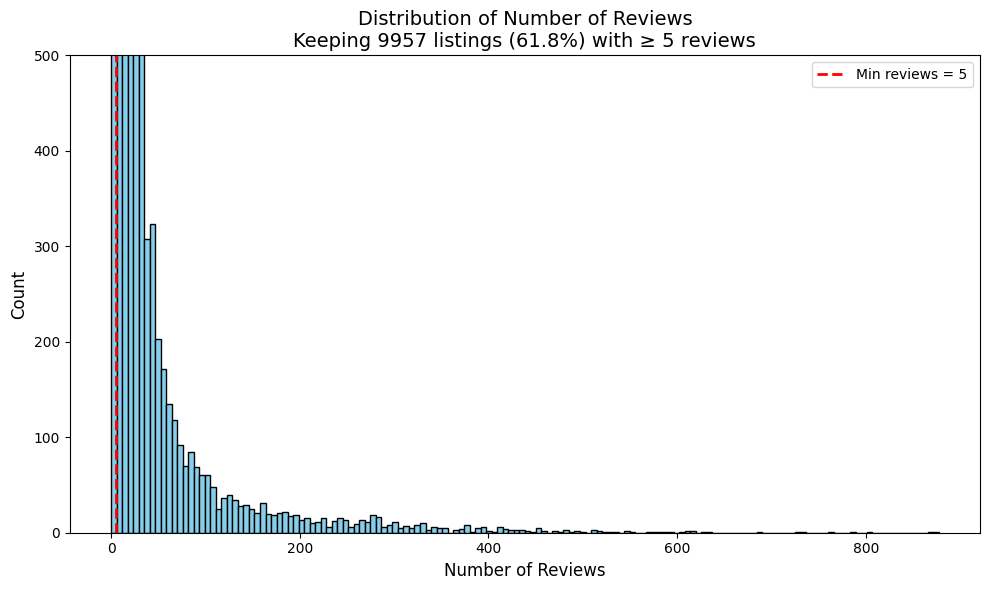

In [4]:
import matplotlib.pyplot as plt

# Set minimum number of reviews
min_reviews = 5

# Compute how many listings would remain
num_remaining = (df_listings_detailed["number_of_reviews"] >= min_reviews).sum()
percent_remaining = num_remaining / len(df_listings_detailed) * 100

# Create figure
fig, ax = plt.subplots(figsize=(10, 6))

# Plot histogram
ax.hist(df_listings_detailed["number_of_reviews"], bins=150, color='skyblue', edgecolor='black')

# Add vertical line for minimum reviews
ax.axvline(min_reviews, color='red', linestyle='--', linewidth=2, label=f'Min reviews = {min_reviews}')

# Labels and title
ax.set_xlabel('Number of Reviews', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_ylim(0, 500)
ax.set_title(f'Distribution of Number of Reviews\n'
             f'Keeping {num_remaining} listings ({percent_remaining:.1f}%) with ≥ {min_reviews} reviews',
             fontsize=14)

# Add legend
ax.legend()

plt.tight_layout()
plt.show()


In [5]:
df_listings_detailed = df_listings_detailed[(df_listings_detailed["number_of_reviews"] >= min_reviews)]

# Creation of amenities_list and price_range

In [6]:
# --- Basic Cleaning ---
df_listings_detailed['host_response_rate'] = df_listings_detailed['host_response_rate'].fillna(0)
df_listings_detailed['host_acceptance_rate'] = df_listings_detailed['host_acceptance_rate'].fillna(0)

# Remove rows with missing or zero price
df_listings_detailed = df_listings_detailed[
    df_listings_detailed["price"].notna() & (df_listings_detailed["price"] > 0)
]

# --- Price Binning ---
max_price = df_listings_detailed['price'].max()
price_bins = [0, 500, 1000, 1500, 2000, max(max_price, 2001)]
price_labels = ['0-500', '500-1000', '1000-1500', '1500-2000', '2000+']

df_listings_detailed['price_range'] = pd.cut(
    df_listings_detailed['price'],
    bins=price_bins,
    labels=price_labels,
    include_lowest=True
)

# --- Host Response Time Encoding ---
df_listings_detailed["host_response_time"] = df_listings_detailed["host_response_time"].fillna("Unknown")

cat_cols = ['host_response_time']
dummies = pd.get_dummies(df_listings_detailed[cat_cols], prefix=cat_cols)
df_listings_detailed = pd.concat([df_listings_detailed, dummies], axis=1)

# --- Amenity Processing ---
# Convert amenity strings to lists
df_listings_detailed['amenities_list'] = df_listings_detailed['amenities'].apply(ast.literal_eval)

# Count amenities across listings
amenity_counts = (
    df_listings_detailed
    .explode('amenities_list')['amenities_list']
    .value_counts()
)

top_50_amenities = amenity_counts.head(50).index.tolist()

# Create binary columns for top amenities
for amenity in top_50_amenities:
    df_listings_detailed[f'amenity_{amenity}'] = (
        df_listings_detailed['amenities_list'].apply(lambda x: int(amenity in x))
    )

df_listings_detailed.drop(columns=['amenities_list'], inplace=True)


In [7]:
# -------------------------------
# 1. Host-related features
# -------------------------------
host_features = [
    # 'host_response_time', Nan too high
    # 'host_response_rate', Nan too high
    # 'host_acceptance_rate', Nan too high
    # 'host_is_superhost',
    'host_listings_count',
    'host_total_listings_count',
    #'host_verifications', Out of scope
    'host_has_profile_pic',
    'host_identity_verified',
    'host_response_time_Unknown',
             'host_response_time_a few days or more', 'host_response_time_within a day', 
             'host_response_time_within a few hours', 'host_response_time_within an hour'
]

# -------------------------------
# 2. Location features
# -------------------------------
location_features = [
    'neighbourhood_cleansed',
    # 'latitude',
    # 'longitude'
]

# -------------------------------
# 3. Property characteristics
# -------------------------------
property_features = [
    # 'property_type', Too many categories
    'room_type', #Entire home/apt    10381 Private room        2727 Hotel room            81 Shared room           36
    'accommodates',
    # 'bathrooms', # Nan too high
    'bedrooms',
    'beds',
    #'amenities' Out of scope
]

# -------------------------------
# 4. Price & stay restrictions
# -------------------------------
price_stay_features = [
    'price',
    # 'minimum_nights',
    # 'maximum_nights',
    # 'minimum_minimum_nights',
    # 'maximum_minimum_nights',
    # 'minimum_maximum_nights',
    # 'maximum_maximum_nights',
    'minimum_nights_avg_ntm',
    'maximum_nights_avg_ntm'
]

# -------------------------------
# 5. Availability / calendar features
# -------------------------------
availability_features = [
    # 'has_availability',
    # 'availability_30',
    # 'availability_60',
    # 'availability_90',
    'availability_365',
    'instant_bookable'
]

# -------------------------------
# 6. Review history (no score leakage)
# -------------------------------
review_history_features = [
    'number_of_reviews',
    # 'number_of_reviews_ltm',
    # 'number_of_reviews_l30d',
    # 'reviews_per_month',
    # 'first_review',
    # 'last_review'
]


amenity_features = [f'amenity_{a}' for a in top_50_amenities]
# -------------------------------
# Combined feature set
# -------------------------------
selected_features = (
    host_features
    + location_features
    + property_features
    + price_stay_features
    + availability_features
    + review_history_features
    + amenity_features
)

print("Total selected features:", len(selected_features))
print(selected_features)


Total selected features: 70
['host_listings_count', 'host_total_listings_count', 'host_has_profile_pic', 'host_identity_verified', 'host_response_time_Unknown', 'host_response_time_a few days or more', 'host_response_time_within a day', 'host_response_time_within a few hours', 'host_response_time_within an hour', 'neighbourhood_cleansed', 'room_type', 'accommodates', 'bedrooms', 'beds', 'price', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'availability_365', 'instant_bookable', 'number_of_reviews', 'amenity_Wifi', 'amenity_Essentials', 'amenity_Heating', 'amenity_Kitchen', 'amenity_Smoke alarm', 'amenity_Hangers', 'amenity_Long term stays allowed', 'amenity_Washer', 'amenity_Shampoo', 'amenity_Dedicated workspace', 'amenity_Hair dryer', 'amenity_Iron', 'amenity_Hot water', 'amenity_Dishes and silverware', 'amenity_Refrigerator', 'amenity_Coffee maker', 'amenity_Cooking basics', 'amenity_Carbon monoxide alarm', 'amenity_Fire extinguisher', 'amenity_Bed linens', 'amenity_Stove', 

In [8]:
# ----------------------------------------
# Prepare data for modelling
# ----------------------------------------
target = 'review_scores_rating'

# Keep original df_listings_detailed index
df = df_listings_detailed[selected_features + [target]].copy()
df.dropna(inplace=True)

# ----------------------------------------
# Split before encoding (keeps original indices)
# ----------------------------------------
X = df[selected_features].copy()
y = df[target].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2
)

# ----------------------------------------
# Identify categorical and numeric columns
# ----------------------------------------
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
numeric_cols = X_train.select_dtypes(exclude=['object', 'category']).columns.tolist()

# ----------------------------------------
# Manual One-Hot Encoding
# ----------------------------------------
# Fit dummies on training only
X_train_cat = pd.get_dummies(X_train[categorical_cols], drop_first=False)

# Apply same dummies to test set
X_test_cat = pd.get_dummies(X_test[categorical_cols], drop_first=False)

# Ensure identical columns in the same order
X_test_cat = X_test_cat.reindex(columns=X_train_cat.columns, fill_value=0)

# ----------------------------------------
# Numeric columns (keep original indices)
# ----------------------------------------
X_train_num = X_train[numeric_cols]
X_test_num  = X_test[numeric_cols]

# ----------------------------------------
# Final preprocessed feature matrices
# ----------------------------------------
X_train_final = pd.concat([X_train_num, X_train_cat], axis=1)
X_test_final  = pd.concat([X_test_num,  X_test_cat], axis=1)




# Model

In [9]:


# ----------------------------------------------------
# Define models and hyperparameter grids
# ----------------------------------------------------
models = {
    'CART': (DecisionTreeRegressor(), {
        'max_depth': [3, 4, 5, 6],
        'min_samples_split': [10, 20, 50]
    }),
    'RandomForest': (RandomForestRegressor(n_jobs=-1), {
        'n_estimators': [100, 200],
        'max_depth': [4, 6, 8]
    }),
    'GradientBoosting': (GradientBoostingRegressor(), {
        'n_estimators': [100, 200],
        'learning_rate': [0.05, 0.1],
        'max_depth': [3, 4]
    }),
    'Ridge': (Ridge(), {
        'alpha': [0.1, 1.0, 10.0]
    }),
    'Lasso': (Lasso(max_iter=10000), {
        'alpha': [0.01, 0.1, 1.0]
    }),
    'XGBoost': (xgb.XGBRegressor(objective='reg:squarederror', n_jobs=-1, random_state=42), {
        'n_estimators': [200, 500],
        'max_depth': [3, 4, 5],
        'learning_rate': [0.05, 0.1]
    })
}

# ----------------------------------------------------
# Run GridSearchCV for each model and record scores
# ----------------------------------------------------
results = []

for name, (model, param_grid) in models.items():
    print(f"Training {name}...")
    grid = GridSearchCV(model, param_grid, cv=3, scoring='r2', n_jobs=-1)
    grid.fit(X_train_final, y_train)
    
    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test_final)
    
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    results.append({
        'Model': name,
        'Best_Params': grid.best_params_,
        'R2': r2,
        'RMSE': rmse
    })

# ----------------------------------------------------
# Save results to DataFrame and sort by R2
# ----------------------------------------------------
results_df = pd.DataFrame(results).sort_values('R2', ascending=False)
results_df


Training CART...
Training RandomForest...
Training GradientBoosting...
Training Ridge...
Training Lasso...
Training XGBoost...


,Model,Best_Params,R2,RMSE
5,XGBoost,"{'learning_rate': 0.05, 'max_depth': 3, 'n_est...",0.152573,0.203158
1,RandomForest,"{'max_depth': 8, 'n_estimators': 200}",0.141809,0.204444
2,GradientBoosting,"{'learning_rate': 0.05, 'max_depth': 3, 'n_est...",0.135461,0.205199
3,Ridge,{'alpha': 10.0},0.120740,0.206939
4,Lasso,{'alpha': 0.01},0.073543,0.212420
0,CART,"{'max_depth': 3, 'min_samples_split': 50}",0.040846,0.216136


                                           feature  importance
0                                            price    0.100536
1                                number_of_reviews    0.092749
2                    amenity_Dishes and silverware    0.063179
3                        host_total_listings_count    0.059162
4                              host_listings_count    0.058610
5                           minimum_nights_avg_ntm    0.051136
6                                             beds    0.041494
7                           maximum_nights_avg_ntm    0.032875
8   neighbourhood_cleansed_De Pijp - Rivierenbuurt    0.028981
9                                     accommodates    0.024214
10                                availability_365    0.022228
11                               amenity_Hot water    0.020073
12                                    amenity_Iron    0.019774
13                              amenity_Hair dryer    0.019442
14                                  amenity_Washer    0

<Axes: ylabel='feature'>

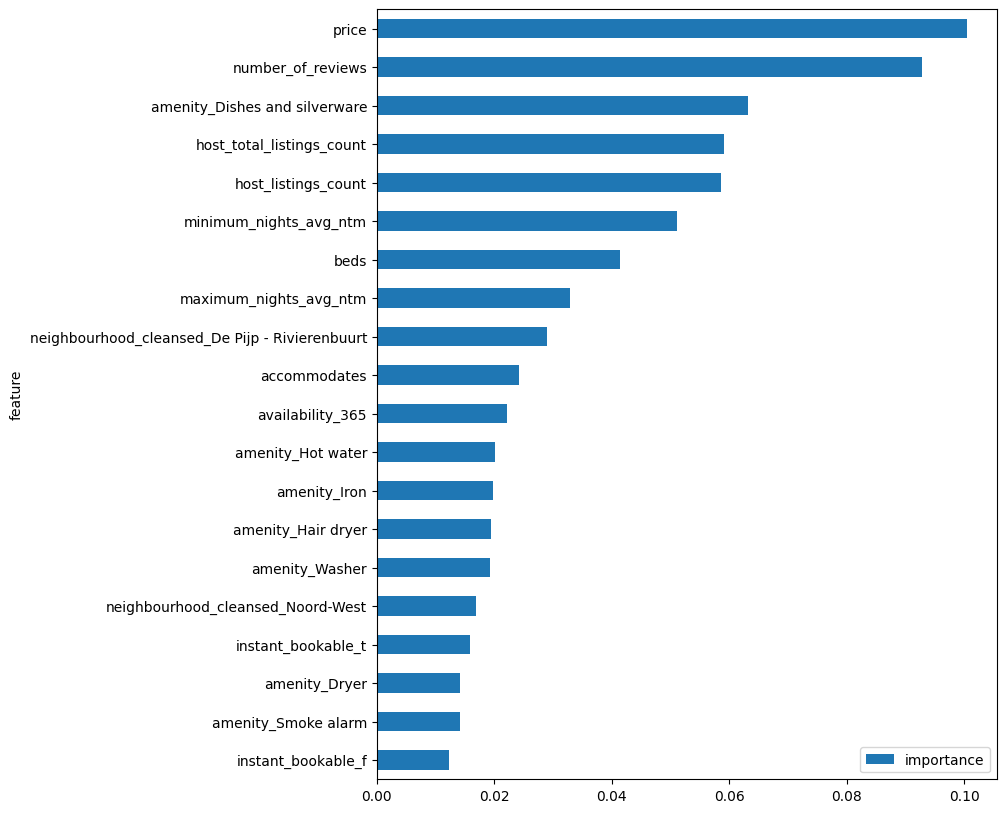

In [10]:
model = RandomForestRegressor(**results_df.loc[results_df['Model'] == 'RandomForest', 'Best_Params'].values[0])

model.fit(X_train_final, y_train)

importances = model.feature_importances_
feature_names = X_train_final.columns

feature_importance_df = (
    pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    })
    .sort_values('importance', ascending=False)
    .reset_index(drop=True)
)

feature_importance_df = feature_importance_df[feature_importance_df['importance'] > 0]


print(feature_importance_df.head(20))   # show top 20

feature_importance_df.head(20).sort_values('importance').plot(
        kind='barh',
        x='feature',
        y='importance',
        figsize=(8, 10))


# Lime

# Lime Local

In [11]:
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_final.values,
    feature_names=X_train_final.columns.tolist(),
    class_names=['review_scores_rating'],
    mode='regression'
)


In [12]:
import random

c:\Users\mhoogeb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\mhoogeb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\mhoogeb\AppData\Local\Temp\ipykernel_22808\3684148395.py:61: DeprecationWarning: *scattermapbox* is deprecated! Use *scattermap* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/
  map_fig = go.Figure(go.Scattermapbox(


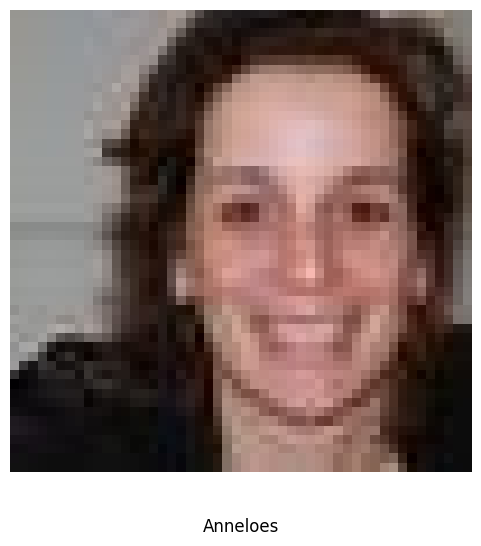

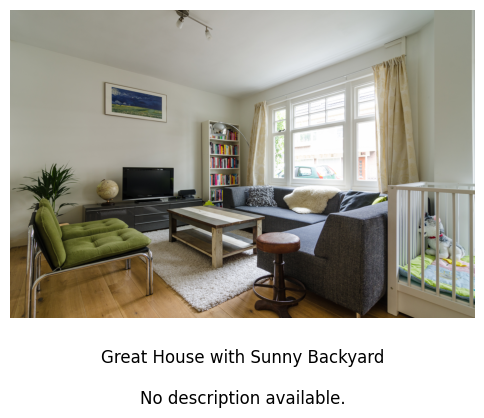

In [13]:
i = random.randint(0, len(X_test_final) - 1)  # inclusive range
listing_data = df_listings_detailed.loc[X_test_final.index[i]]
predicted_score = round(model.predict([X_test_final.iloc[i].values])[0], 2)
actual_review_score = round(np.array(y_test)[i],2)



exp = explainer.explain_instance(
    data_row=X_test_final.iloc[i].values,
    predict_fn=model.predict,
    num_features=15    # top features to show
)

lime_exp_list = exp.as_list()

# Convert to DataFrame
exp_df = pd.DataFrame(lime_exp_list, columns=['feature', 'contribution'])

exp_df['contribution'] = round(exp_df['contribution'],4)


#Sorting
exp_df['abs_contribution'] = exp_df['contribution'].abs()
exp_df = exp_df.sort_values('abs_contribution', ascending=True)  # for horizontal bar plot


# ----------------------------------------------------
# Extract data
# ----------------------------------------------------
lat = float(listing_data["latitude"])
lon = float(listing_data["longitude"])
listing_title = listing_data.get("name", "No Title")
host_name = listing_data.get("host_name", "Unknown Host")
host_img_url = listing_data.get("host_thumbnail_url", None)
host_description = listing_data.get("host_about", "No description available.")
picture_url = listing_data.get("picture_url", None)  # if you want clickable URLs



# Load host image if available
host_img = None
if host_img_url and isinstance(host_img_url, str) and host_img_url.startswith("http"):
    try:
        response = requests.get(host_img_url)
        host_img = Image.open(BytesIO(response.content))
    except:
        host_img = None

# Load listing image
listing_img = None
if picture_url and isinstance(picture_url, str) and picture_url.startswith("http"):
    try:
        response = requests.get(picture_url)
        listing_img = Image.open(BytesIO(response.content))
    except:
        listing_img = None        

# ----------------------------------------------------
# 1. Map plot using Plotly
# ----------------------------------------------------
map_fig = go.Figure(go.Scattermapbox(
    lat=[lat],
    lon=[lon],
    mode="markers",
    marker=dict(size=14, color="red"),
    text=[listing_title]
))

map_fig.update_layout(
    mapbox=dict(
        style="open-street-map",
        zoom=12,
        center=dict(lat=lat, lon=lon)
    ),
    title_text="Listing Location",
    height=500,
    width=700,
    margin=dict(l=0, r=0, t=0, b=0)
)

map_fig.show()

# ----------------------------------------------------
# 2. Host Info using Matplotlib
# ----------------------------------------------------
fig, ax = plt.subplots(figsize=(6, 6))
ax.axis('off')  # Hide axes

if host_img is not None:
    ax.imshow(host_img)
ax.text(0.5, -0.1, f"{host_name}",
        ha='center', va='top', wrap=True, fontsize=12, transform=ax.transAxes)

plt.show()

# ----------------------------------------------------
# 2. Listing Image
# ----------------------------------------------------
fig, ax = plt.subplots(figsize=(6, 6))
ax.axis('off')  # Hide axes

if listing_img is not None:
    ax.imshow(listing_img)
ax.text(0.5, -0.1, f"{listing_title}\n\n{host_description}",
        ha='center', va='top', wrap=True, fontsize=12, transform=ax.transAxes)

plt.show()


# ----------------------------------------------------
# 3. LIME Feature Contributions (Plotly Bar)
# ----------------------------------------------------
lime_fig = go.Figure(go.Bar(
    x=exp_df['contribution'],
    y=exp_df['feature'],
    orientation='h',
    marker=dict(
        color=exp_df['contribution'],
        colorscale='RdBu',
        cmin=-exp_df['abs_contribution'].max(),
        cmax=exp_df['abs_contribution'].max()
    ),
    text=exp_df['contribution'],
    textposition='auto',
    textfont=dict(size=32)  # Increase font size of bar text

))

lime_fig.update_layout(
    title_text=f"LIME Feature Contributions (Predicted: {predicted_score}, Actual: {actual_review_score})",
    width=900,
    paper_bgcolor='white'
    
)

lime_fig.show()


